In [12]:
import numpy as np
import pickle

In [13]:
X=np.load('../processed/X.npy')
y=np.load('../processed/y.npy')
embedding_matrix=np.load('../processed/embedding_matrix.npy')

with open('../processed/tokenizer.pkl','rb') as f:
    tokenizer=pickle.load(f)

print(f"Shape of X : {X.shape}")
print(f"Shape of y : {y.shape}")
print(f"Shape of Embedding Matrix : {embedding_matrix.shape}")

Shape of X : (159505, 200)
Shape of y : (159505, 6)
Shape of Embedding Matrix : (50000, 100)


In [23]:
MODEL_DIR     = '../models/'

os.makedirs(MODEL_DIR, exist_ok=True)

In [14]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Embedding,Bidirectional,LSTM,Dense,Dropout,GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import os

In [18]:
x_train,x_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=42)

In [19]:
print(f"x_train shape : {x_train.shape}")
print(f"x_val shape : {x_val.shape}")

x_train shape : (127604, 200)
x_val shape : (31901, 200)


In [20]:
MAX_WORDS     = 50000
MAX_LEN       = 200
EMBEDDING_DIM = 100

### **Model Training**

In [21]:
def build_bidirectional_lstm():
    inputs=Input(shape=(MAX_LEN,))
    x=Embedding(
        input_dim=MAX_WORDS,
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_LEN,
        trainable=False
    )(inputs)
    
    x=Bidirectional(LSTM(128,return_sequences=True))(x)
    x=Dropout(0.3)(x)
    x=Bidirectional(LSTM(64,return_sequences=True))(x)
    x=Dropout(0.3)(x)
    x=GlobalMaxPooling1D()(x)
    x=Dense(64,activation='relu')(x)
    x=Dropout(0.3)(x)

    outputs=Dense(6,activation='sigmoid')(x)

    model=Model(inputs,outputs)
    return model

model=build_bidirectional_lstm()
model.summary()


/opt/anaconda3/envs/toxic_comment_classifier/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 200, 100)       │     5,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200, 256)       │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 200, 128)       │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,407,494 (20.63 MB)

 Trainable params: 407,494 (1.55 MB)

 Non-trainable params: 5,000,000 (19.07 MB)

In [22]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

In [24]:
callbacks=[
    EarlyStopping(
        monitor='val_auc',
        patience=3,
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    ModelCheckpoint(
        filepath=f"{MODEL_DIR}bilstm.keras",
        monitor='val_auc',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

In [ ]:
history=model.fit(
    x_train,y_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_val,y_val),
    sample_weight=sample_weights,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
3988/3988 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.8476 - auc: 0.9322 - loss: 0.0853
Epoch 1: val_auc improved from None to 0.98084, saving model to ../models/bilstm.keras
3988/3988 ━━━━━━━━━━━━━━━━━━━━ 1409s 353ms/step - accuracy: 0.9344 - auc: 0.9628 - loss: 0.0659 - val_accuracy: 0.9933 - val_auc: 0.9808 - val_loss: 0.0612
Epoch 2/10
3988/3988 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.9853 - auc: 0.9755 - loss: 0.0538
Epoch 2: val_auc improved from 0.98084 to 0.98256, saving model to ../models/bilstm.keras
3988/3988 ━━━━━━━━━━━━━━━━━━━━ 1383s 347ms/step - accuracy: 0.9837 - auc: 0.9768 - loss: 0.0529 - val_accuracy: 0.9933 - val_auc: 0.9826 - val_loss: 0.0531
Epoch 3/10
3988/3988 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.9836 - auc: 0.9795 - loss: 0.0496
Epoch 3: val_auc improved from 0.98256 to 0.98344, saving model to ../models/bilstm.keras
3988/3988 ━━━━━━━━━━━━━━━━━━━━ 1365s 342ms/step - accuracy: 0.9841 - auc: 0.9802 - loss: 0.0492 - val_accurac

### **Plotting Results**

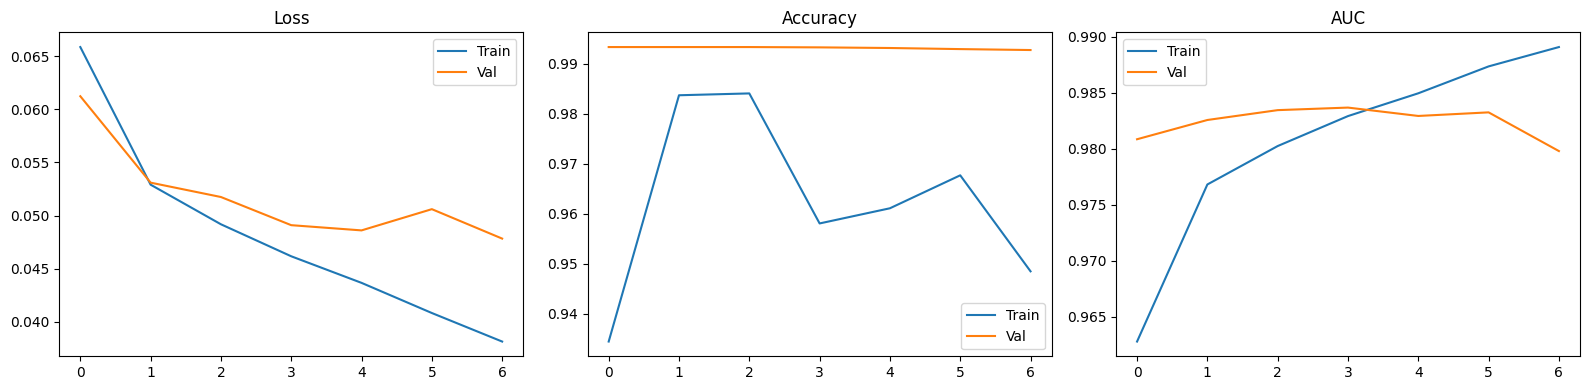

In [27]:
def plot_history(history):
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))

    axes[0].plot(history.history['loss'], label='Train')
    axes[0].plot(history.history['val_loss'], label='Val')
    axes[0].set_title('Loss')
    axes[0].legend()

    axes[1].plot(history.history['accuracy'], label='Train')
    axes[1].plot(history.history['val_accuracy'], label='Val')
    axes[1].set_title('Accuracy')
    axes[1].legend()

    axes[2].plot(history.history['auc'], label='Train')
    axes[2].plot(history.history['val_auc'], label='Val')
    axes[2].set_title('AUC')
    axes[2].legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

plot_history(history)

    

### **Evaluate**

In [30]:
LABEL_COLS = ['toxic', 'severe_toxic', 'obscene','threat', 'insult', 'identity_hate']
thresholds = {
    'toxic'        : 0.5,
    'severe_toxic' : 0.3,  # lower threshold
    'obscene'      : 0.5,
    'threat'       : 0.2,  # very low threshold
    'insult'       : 0.5,
    'identity_hate': 0.3   # lower threshold
}

y_pred = model.predict(x_val)

# Apply custom thresholds
y_pred_custom = np.zeros_like(y_pred)
for i, label in enumerate(LABEL_COLS):
    y_pred_custom[:, i] = (y_pred[:, i] > thresholds[label]).astype(int)

# Compare results
print('Results with custom thresholds:')
for i, label in enumerate(LABEL_COLS):
    print(f'\n--- {label.upper()} ---')
    print(classification_report(y_val[:, i], y_pred_custom[:, i]))

997/997 ━━━━━━━━━━━━━━━━━━━━ 103s 104ms/step
Results with custom thresholds:

--- TOXIC ---
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     28906
           1       0.84      0.71      0.77      2995

    accuracy                           0.96     31901
   macro avg       0.91      0.85      0.88     31901
weighted avg       0.96      0.96      0.96     31901


--- SEVERE_TOXIC ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     31608
           1       0.48      0.49      0.48       293

    accuracy                           0.99     31901
   macro avg       0.74      0.74      0.74     31901
weighted avg       0.99      0.99      0.99     31901


--- OBSCENE ---
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     30215
           1       0.89      0.71      0.79      1686

    accuracy                           0.98     319

In [31]:
import json

thresholds = {
    'toxic'        : 0.5,
    'severe_toxic' : 0.3,
    'obscene'      : 0.5,
    'threat'       : 0.2,
    'insult'       : 0.5,
    'identity_hate': 0.3
}

with open('../models/thresholds.json', 'w') as f:
    json.dump(thresholds, f)

print('Thresholds saved!')

Thresholds saved!
